# Загрузка Pandas и очистка данных

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns

import re
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

%matplotlib inline

RANDOM_SEED = 42

## Предобработка

In [26]:
def rename_columns(df):
    '''
    Функция приводит названия колонок к единому формату.
    '''

    columns = {}
    for column in df.columns:
        columns[column] = column.lower().strip().replace(' ', '_')
    return df.rename(columns=columns, inplace=True)


def missing_data(df):
    '''
    Отображает процент пропусков по каждой колонке.
    '''
    for column in df.columns:
        missing = df[column].isnull().sum()
        percent_of_missing = np.mean(df[column].isnull())
        if missing > 0:
            print('{} - {} values, {:.2f}%'.format(column, missing, percent_of_missing*100))
            
            
def IQR_outlier(column, verbose=True):
    '''
    Функция для отображения границ межквартильного размаха
    '''
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    IQR = perc75 - perc25
    low = perc25 - 1.5*IQR
    high = perc75 + 1.5*IQR
    if verbose:
        print('25-й перцентиль: {},'.format(perc25)[:-1], '75-й перцентиль: {},'.format(perc75),
            "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=low, l=high))
    return (low, high)

## Импорт данных

In [3]:
df = pd.read_csv('main_task.csv')
rename_columns(df)

## Детальный анализ

In [4]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      40000 non-null  object 
 1   city               40000 non-null  object 
 2   cuisine_style      30717 non-null  object 
 3   ranking            40000 non-null  float64
 4   rating             40000 non-null  float64
 5   price_range        26114 non-null  object 
 6   number_of_reviews  37457 non-null  float64
 7   reviews            40000 non-null  object 
 8   url_ta             40000 non-null  object 
 9   id_ta              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


None

In [5]:
missing_data(df)

cuisine_style - 9283 values, 23.21%
price_range - 13886 values, 34.72%
number_of_reviews - 2543 values, 6.36%


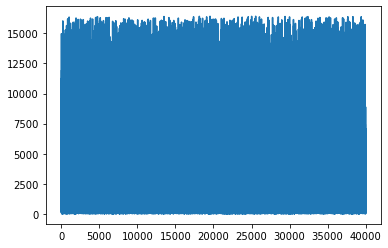

In [6]:
x = df['restaurant_id'].apply(lambda x: x[3:]).astype('int16')
plt.plot(x)

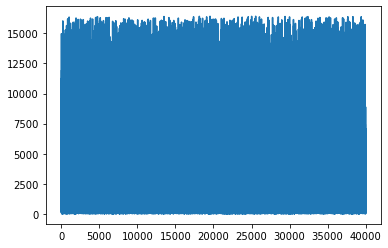

In [7]:
x= df['restaurant_id'].apply(lambda x: x[x.find('_')+1:]).astype('int32')
plt.plot(x)

## Вопросы

In [8]:
display(df.head())
df.info()

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      40000 non-null  object 
 1   city               40000 non-null  object 
 2   cuisine_style      30717 non-null  object 
 3   ranking            40000 non-null  float64
 4   rating             40000 non-null  float64
 5   price_range        26114 non-null  object 
 6   number_of_reviews  37457 non-null  float64
 7   reviews            40000 non-null  object 
 8   url_ta             40000 non-null  object 
 9   id_ta              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


### 

In [9]:
df['price_range'].value_counts()

$$ - $$$    18412
$            6279
$$$$         1423
Name: price_range, dtype: int64

### 

In [10]:
df['city'].nunique()

31

### 

In [11]:
cuisine_series = df[df['cuisine_style'].notnull()]['cuisine_style']
cuisine_series = cuisine_series.apply(lambda x: x[1:-1].lower()).str.split(', ')
cuisine_series.explode().nunique()

125

In [12]:
cuisine_series.explode().value_counts().head(1)

'vegetarian friendly'    11189
Name: cuisine_style, dtype: int64

In [13]:
cuisine_series_nan = df[df['cuisine_style'].isnull()]['cuisine_style']
cuisine_series_nan = cuisine_series_nan.fillna('Unknown').str.split()

In [14]:
cuisine_mode = cuisine_series.append(cuisine_series_nan)
average_cuisine = 0
for cuisine in cuisine_mode:
    average_cuisine += len(cuisine) / len(cuisine_mode)
print(round(average_cuisine, 1))

2.6


### 

In [15]:
pattern = re.compile('\d+\/\d+\/\d+')
x = pattern.findall(df['reviews'][0])
print(x)
y = datetime.strptime(x[0], '%m/%d/%Y')
print(y)

['12/31/2017', '11/20/2017']
2017-12-31 00:00:00


## Обработка датасета

### Feature engineering

In [16]:
dates = df['reviews'].str.findall('\d+\/\d+\/\d+')
df['first_review'] = dates.apply(lambda x: pd.to_datetime(x).min())
df['last_review'] = dates.apply(lambda x: pd.to_datetime(x).max())
# Создадим колонку с разницей между первым и вторым отзывом.
df['difference_dates_of_reviews'] = df['last_review'] - df['first_review']
df['difference_dates_of_reviews'] = df['difference_dates_of_reviews'].apply(lambda x: x.days)  # выразим в формате дней.
# Заменим пропуски средним значением
df['difference_dates_of_reviews'].fillna(df['difference_dates_of_reviews'].mean(), inplace=True)

In [17]:
# Создадим словарь в котором отражено население и площадь каждого города МАЕ 0,21239
cities = list(sorted(df['city'].unique()))
# Населенеи выражено в млн.чел
population = [0.825080, 3.168846, 0.424819, 3.326002, 0.413192, 0.176545, 1.744665, 1.246611, 0.506211,
              0.482005, 0.198899, 1.718187, 0.574579, 0.756183, 0.547733, 0.277554, 8.538689, 0.214,
              0.506615, 3.155360, 1.331586, 1.561094, 0.258975, 0.673469, 2.148327, 1.272690,  2.870493,
              0.961609, 1.765649, 1.720398, 0.402275]
area = [219.4, 412, 101.3, 891.68, 368, 32.61, 525.14, 86.40, 318, 118, 15.93, 755.09, 213.8, 327, 100.05,
        163.8, 1572, 51.47, 47.87, 607, 181.67, 310.71, 41.66, 454, 105.4, 496, 1287.36, 188, 414.75, 517, 91.88]
city_population_dict = dict(zip(cities, population))
city_area_dict = dict(zip(cities, area))
# city_population_dict
# city_area_dict
df['city_area'] = df['city'].map(lambda x: city_area_dict[x])
df['city_population'] = df['city'].map(lambda x: city_population_dict[x])

In [18]:
# Определим количество ресторанов в каждом городе.
restorants_in_city = df.groupby('city')['ranking'].count().to_dict()
df['restaurants_count'] = df['city'].map(restorants_in_city)
# Количество ресторанов на 10_000 человек
df['restaurants_for_population'] = df['restaurants_count'] / (df['city_population'] * 10_000)

In [19]:
df

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta,first_review,last_review,difference_dates_of_reviews,city_area,city_population,restaurants_count,restaurants_for_population
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,2017-11-20,2017-12-31,41.000000,105.40,2.148327,4897,0.227945
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,2016-06-19,2017-07-06,382.000000,188.00,0.961609,820,0.085274
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,2018-01-06,2018-01-08,2.000000,1572.00,8.538689,5757,0.067423
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,NaT,NaT,122.455993,891.68,3.326002,2155,0.064793
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,2017-02-19,2017-11-18,272.000000,310.71,1.561094,893,0.057203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,4.5,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,2017-11-12,2017-12-16,34.000000,181.67,1.331586,2133,0.160185
39996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,3.5,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,2017-12-12,2017-12-21,9.000000,105.40,2.148327,4897,0.227945
39997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,4.5,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,2008-04-12,2016-11-03,3127.000000,188.00,0.961609,820,0.085274
39998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,4.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,2017-06-18,2017-07-11,23.000000,517.00,1.720398,727,0.042258


In [20]:
# Количество кухонь в ресторане. Пропущенные значения заменены на 1.
df['cuisine_variety'] = df['cuisine_style'].str.split(', ').map(lambda x: len(x) if type(x) == list else 1)
# Сохраним информацию о пропусках
df['cuisine_style_isNAN'] = pd.isna(df['cuisine_style']).astype('uint8')

In [27]:
IQR_outlier('cuisine_variety')

25-й перцентиль: 1.0 75-й перцентиль: 4.0, IQR: 3.0,  Границы выбросов: [-3.5, 8.5].


(-3.5, 8.5)

In [ ]:
# Избавимся от пропусков в данных
df['number_of_reviews'].fillna(0, inplace=True)
# Добавим столбец с информацией о пропусках
df['number_of_reviews_isNAN'] = pd.isna(df['number_of_reviews']).astype('uint8')
# Как часто в городе оставляют отзывы
df['frequency_of_reviews'] = df['number_of_reviews'] / df['city_population']

In [ ]:
# Добавим столбцы с информацией о пропусках
# df['price_range_isNAN'] = pd.isna(df['price_range']).astype('uint8')

### Сделаем Dummy-encoding

In [ ]:
# Проведем dummy-кодирование по признаку city
# ohe = OneHotEncoder(sparse=False)
# new_ohe_features = ohe.fit_transform(df['city'].values.reshape(-1, 1))
# tmp = pd.DataFrame(new_ohe_features, columns=['city=' + str(i) for i in range(new_ohe_features.shape[1])])
# df = pd.concat([df, tmp], axis=1)

In [ ]:
df['price_range'].fillna('$$ - $$$', inplace=True)
# Проведем Label-encoding параметра price_range
# dic_value_price = {'$':1,'$$ - $$$':2,'$$$$':3}
# df['price_range'] = df['price_range'].map(dic_value_price)
# Проведем One-Hot-encoding параметра price_range
ohe = OneHotEncoder(sparse=False)
new_ohe_features = ohe.fit_transform(df['price_range'].values.reshape(-1, 1))
tmp = pd.DataFrame(new_ohe_features, columns=['price_range=' + str(i) for i in range(new_ohe_features.shape[1])])
df = pd.concat([df, tmp], axis=1)

In [ ]:
df.head(3)

In [ ]:
drop_column = [*df.columns[:3], 'price_range', *df.columns[7:12]]
# drop_column = [*df.columns[:3], *df.columns[7:12]]
drop_column
df.drop(drop_column, axis=1, inplace=True)

In [ ]:
df.head(3)

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [ ]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['rating'], axis = 1)
y = df['rating']

In [ ]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [ ]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [ ]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [ ]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

In [ ]:
df['cuisine_style'] = df['cuisine_style'].apply(lambda x: str(x).replace(
    "[", "").replace("]", "").replace("'", "").replace().split(", "))